# Imports and Helper Functions

In [1]:
import numpy as np
import pandas as pd
from itertools import product
from scipy.optimize import linprog
from functools import reduce
from math import log, sqrt
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
def rotate(l, n):
    return l[n:] + l[:n]
def tensor_sum(list_of_lists):
    # return a tensor of size len(list_of_lists[0]) x ... x len(list_of_lists[-1]) where the value at index (i_1, ..., i_n) is the sum of the values at the same index in the lists
    shape = tuple(len(lst) for lst in list_of_lists)
    tensor = np.zeros(shape)
    idxes = list(range(len(shape)))
    for idx, l in enumerate(list_of_lists):
        tensor += np.transpose(np.tensordot(l, np.ones(shape[idx+1:] + shape[:idx]), axes=0), axes = rotate(idxes, -idx))
    return tensor
def create_cost_tensor(list_list_of_lists):
    shape = tuple(len(lst) for lst in list_list_of_lists[0])
    res = np.zeros(shape)
    for list_of_lists in list_list_of_lists:
        tensor = tensor_sum(list_of_lists)
        res += (tensor / len(shape)) ** 2
    return res, [1/n for n in shape for _ in range(n)]

def ravel_index(dim, index, shape):
    return sum([shape[i] for i in range(dim)]) + index
def convert_to_list(U, shape):
    U_list = []
    i = 0
    for s in shape:
        U_list.append(U[i:i+s])
        i += s
    return U_list
def marginal_k(X, k):
    # marginalize tensor X over dimension k
    return np.sum(X, axis=tuple(axis for axis in range(X.ndim) if axis != k))
def get_marginal_k(p, k, shape):
    return p[ravel_index(k, 0, shape): ravel_index(k, shape[k], shape)]
def rho(a, b):
    return b - a + a * np.log(a / b)
def projection(X, p):
    V = X.copy()
    m, shape = X.ndim, X.shape
    idxes = list(range(len(shape)))
    for r in range(m):
        X_r = np.minimum(get_marginal_k(p, r, shape) / marginal_k(V, r), 1)
        V *= np.transpose(np.tensordot(X_r, np.ones(shape[r+1:] + shape[:r]), axes=0), axes = rotate(idxes, -r))

    err_list = [get_marginal_k(p, r, shape) - marginal_k(V, r) for r in range(m)]
    V += reduce(np.multiply, np.ix_(*err_list)) / (np.abs(err_list[-1]).sum() ** (m-1))
    return V
def solve_lp(costs, target_mu):
    shape = costs.shape
    A = np.zeros((np.sum(shape), np.prod(shape)))
    for j, s in enumerate(shape):
        for i in range(s):
            for idx in product(*map(range, shape)):
                if idx[j] == i:
                    A[ravel_index(j, i, shape), np.ravel_multi_index(idx, shape)] = 1
    c = costs.flatten()
    res = linprog(c, A_eq=A, b_eq=target_mu, bounds=[0, 1], options = {"tol": 1e-8})
    return res.fun, res.x.reshape(shape)

def binary_search(a, b, f, delta = 1e-3):
    while True:
        c = (a+b)/2
        if f(c+delta) < f(c):
            a = c
        else:
            b = c
        if abs(a-b) <= delta:
            break
    return (a+b)/2

def larger_root_qr(a, b, c):
    delta = (b**2) - (4 * a*c)
    assert delta >= 0
    ans1 = (-b - sqrt(delta))/(2 * a)
    ans2 = (-b + sqrt(delta))/(2 * a)
    return max(ans1, ans2)

def A_stable(costs, eta):
    U_tmp = - costs * eta
    max_U_tmp = U_tmp.max().max()
    U_tmp = np.maximum(U_tmp, max_U_tmp - MAX_DIGIT)
    min_U_tmp = U_tmp.min().min()
    return np.exp(U_tmp - min_U_tmp), min_U_tmp

def solve_greenkhorn(costs, target_mu, epsilon=1e-2, verbose = 0, cost_scale = 1, iter_gap = 100):
    """solve using Greenkhorn's algorithm

    Args:
        costs (array)
        target_mu (list): target probability
        epsilon (float): precision. Defaults to 1e-2.
        verbose (int, optional): print intermediate results if verbose >= 2. Defaults to 0.
        cost_scale (int, optional): divide the cost matrix by cost_scale before calculating, scale back in the end. Defaults to 1.
        iter_gap (int, optional): print results every `iter_gap` iterations. Defaults to 100.

    Returns:
        _type_: _description_
    """
    costs /= cost_scale
    shape = costs.shape
    eta = 4 * sum([log (n) for n in shape]) / epsilon
    epsilon_prime = epsilon / 8 / costs.max()
    min_cost = costs.min()
    A_stable = np.exp(-eta * (costs - min_cost))
    A = np.exp(-eta * min_cost) * A_stable
    m = [np.zeros(s) for s in shape]
    B = A_stable / np.sum(np.abs(A_stable))
    def dist(B):
        return sum(np.sum(np.abs(marginal_k(B, i) - get_marginal_k(target_mu, i, shape))) for i in range(B.ndim))
    iter = 0
    if verbose >= 2: obj_list = []
    if verbose >= 2: print("epsilon_prime: ", epsilon_prime)
    while dist(B) > epsilon_prime:
        iter += 1
        max_v = []
        buffer = []
        for k in range(B.ndim):
            marginal = marginal_k(B, k)
            tmp = rho(marginal, get_marginal_k(target_mu, k, shape))
            im = np.argmax(tmp)
            max_v.append(tmp[im])
            buffer.append((marginal[im], im))
        kmax = np.argmax(max_v)
        rki, imax = buffer[kmax]
        m[kmax][imax] += np.log(target_mu[ravel_index(kmax, imax, shape)] / rki)
        if verbose >= 100: print("tensor_sum max", tensor_sum(m).max(), tensor_sum(m).min())
        B = A * np.exp(tensor_sum(m))
        if verbose >= 2 and iter % iter_gap == 0:
            obj = np.sum(projection(B, target_mu) * costs) * cost_scale
            print("iter: ", iter, "dist: ", dist(B), "obj: ", obj)
            obj_list.append(obj)
    if verbose >= 2:
        plt.plot(np.array(range(len(obj_list))) * iter_gap, obj_list)
        plt.title("Primal objective over iterations")
        plt.show()
    weights = projection(B, target_mu)
    return np.sum(weights * costs) * cost_scale, weights
        
def get_res_single(tmp_list, solver = solve_lp, return_res = False, print_res = True):
    costs, target_mu = create_cost_tensor(tmp_list)
    lb = np.sum([np.mean([np.mean(t) for t in tmp])**2 for tmp in tmp_list])
    dis, weight = solver(costs, target_mu)
    if print_res: print("mean sq:", lb, "objective value: ", dis)
    if return_res: return lb, dis, weight
    
def get_bootstrap_res(tmp_list, solver = solve_lp, iterations = 100, skip = False):
    res = []
    while len(res) < iterations:
        # sample with replacement from data where data is a list of tuples (group, value)
        # generate a random list containing integers from 0 to len(data) - 1
        L = sum([len(l) for l in tmp_list[0]])
        data_list = []
        for tmp in tmp_list:
            data = []
            for i, l in enumerate(tmp):
                for c in l:
                    data.append((i, c))
            data_list.append(data)
        sample = np.random.randint(0, L, L)
        
        # split into groups
        groups_list = []
        for data in data_list:
            groups = [[] for _ in range(len(tmp_list[0]))]
            for s in sample:
                i, c = data[s]
                groups[i].append(c)
            groups_list.append(groups)
            
        # get results
        flag = False
        for g in groups_list[0]:
            if len(g) == 0:
                flag = True
                break
        if flag:
            if not skip:
                new_groups = []
                for g in groups_list:
                    new_groups.append([l for l in g if len(l) > 0])
                lb, dis, _ = get_res_single(new_groups, solver = solver, return_res = True, print_res = False)
                res.append((lb, dis))
        else:
            lb, dis, _ = get_res_single(groups_list, solver = solver, return_res = True, print_res = False)
            res.append((lb, dis))
    return res

# Data and Solve LP

In [3]:
# import csv file
file_name = 'weight loss processed.csv' # change this to the name of the file
value_col = 'weight.loss' # change this to the column name of the value for the first dimension
# value_col1 = 'altruism' # change this to the column name of the value for the second dimension
data = pd.read_csv('data/' + file_name).dropna(subset=[value_col]).drop(columns = ["Unnamed: 0"])
margin_col = ['treatment'] # change this to the list of columns to be used as margins
value = data.groupby(margin_col)[value_col].apply(list)
# value1 = data.groupby(margin_col)[value_col1].apply(list)

## Single Runs

epsilon_prime:  0.022981901752370006
iter:  1 dist:  29533.321449302144 obj:  6.1788255764680695
iter:  2 dist:  22904.293507081344 obj:  6.092423193100791
iter:  3 dist:  17114.188081872173 obj:  6.002591169516338
iter:  4 dist:  11548.781389485039 obj:  5.683609698005693
iter:  5 dist:  6514.302897784588 obj:  5.548819099446121
iter:  6 dist:  3432.9620909420078 obj:  5.473107056861521
iter:  7 dist:  650.0297341150534 obj:  5.399949338632476
iter:  8 dist:  2.5436625979748815 obj:  6.188969936461098
iter:  9 dist:  2.59102686949384 obj:  6.327164754524723
iter:  10 dist:  2.554006650181816 obj:  6.327164754524723
iter:  11 dist:  2.5285959250313983 obj:  6.327164754524723
iter:  12 dist:  2.666849347829893 obj:  6.134444648245316
iter:  13 dist:  2.60140617397187 obj:  6.163469946693793
iter:  14 dist:  2.5895497918741643 obj:  6.101717052673388
iter:  15 dist:  2.612833506474473 obj:  6.154640228854232
iter:  16 dist:  2.6199559761266804 obj:  6.121484895880651
iter:  17 dist:  2.6

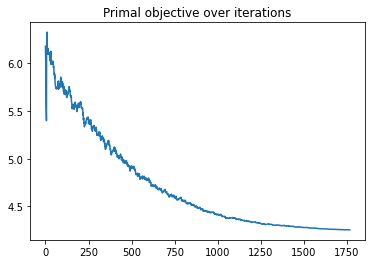

mean sq: 4.1316372470042255 objective value:  4.253944229245145
single run: 9.306018959 seconds


In [6]:
import time
tic = time.perf_counter()
# works for 10samples
# 
lb, dis, weight = get_res_single([[sorted(l) for l in value.values]], solver = lambda a, b: solve_greenkhorn(a, b, epsilon=1, verbose = 2, cost_scale = 10, iter_gap = 1), return_res = True)
toc = time.perf_counter()
print(f"single run: {toc - tic} seconds")